In [1]:
import ROOT
import math
# Colors
from ROOT import kYellow, kBlue, kRed, kGreen
import numpy as np
from rootpy.plotting import Hist, HistStack, Legend, Canvas, set_style
from rootpy.plotting.style import get_style, set_style
from rootpy.plotting.utils import draw
from rootpy.interactive import wait
import rootpy.plotting.root2matplotlib as rplt
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from root_numpy import root2array, tree2array
from root_numpy import testdata, fill_hist
import pandas as pd

Welcome to JupyROOT 6.14/04


DEBUG:matplotlib] $HOME=/home/andrea
DEBUG:matplotlib] matplotlib data path /home/andrea/anaconda3/lib/python3.5/site-packages/matplotlib/mpl-data
DEBUG:matplotlib] loaded rc file /home/andrea/anaconda3/lib/python3.5/site-packages/matplotlib/mpl-data/matplotlibrc
DEBUG:matplotlib] matplotlib version 2.2.3
DEBUG:matplotlib] interactive is False
DEBUG:matplotlib] platform is linux
DEBUG:matplotlib] loaded modules: ['multiprocessing.util', 'rootpy.plotting.profile', 'zmq.backend.cython', 'simplegeneric', 'rootpy.decorators', 'sqlite3.dbapi2', 'zmq.backend.cython.error', 'zmq.sugar.tracker', 'pathlib', 'ROOT.TArrayF', 'concurrent.futures._base', 'mkl_fft._numpy_fft', 'numpy._mklinit', 'parso.python.pep8', 'fnmatch', 'zmq.utils', 'pexpect.spawnbase', 'parso.python.diff', 'logging.handlers', 'traitlets.config.loader', 'ctypes.util', 'JupyROOT.cppcompleter', 'plistlib', 'IPython.utils.ipstruct', 'ipython_genutils', 'pygments.modeline', 'IPython.core.alias', 'jupyter_client.adapter', 'zmq.back

DEBUG:matplotlib] CACHEDIR=/home/andrea/.cache/matplotlib
DEBUG:matplotlib.font_manager] Using fontManager instance from /home/andrea/.cache/matplotlib/fontList.json
DEBUG:matplotlib.backends] backend module://ipykernel.pylab.backend_inline version unknown
DEBUG:matplotlib.backends] backend module://ipykernel.pylab.backend_inline version unknown


## Matplotlib Function

In [35]:
def getTHLimits(file_path, ttree, var):
    g_min = 99999999999.
    g_max = -99999999999.
    aux = ROOT.TFile.Open(file_path)
    tree = aux.Get(ttree)
    maxv=int(round(tree.GetMaximum(var)))
    minv=int(round(tree.GetMinimum(var)))
    return minv-1.,maxv+1.

In [66]:
def hist_gen(file, data, background, signal, ttree, var, region, nbins):
    
    rfile = ROOT.TFile(file)
    intree = rfile.Get(ttree)
    array = tree2array(intree)
    df = pd.DataFrame(array)
    df = df.loc[df['m_region'] == region]
    
    # data, background and signal are filenames arrays
    arrB = df.loc[df['sample'].isin(background)]
    arrS = df.loc[df['sample'].isin(signal)]
    arrD = df.loc[df['sample'].isin(data)]
    
    # set the style
    style = get_style('ATLAS')
    style.SetEndErrorSize(3)
    set_style(style)
    
    # create histograms
    hmin, hmax = getTHLimits(file, ttree, var)
    h = Hist(nbins, hmin, hmax, markersize=0, legendstyle='F')
    h_sig = []
    h_bkg = []
    colorsS = ['red', 'firebrick']
    colorsB = ['blue', 'yellow', 'green', 'purple', 'orange', 'skyblue', 'lightsalmon', 'olivedrab', 'slateblue', 'sandybrown', 'turquoise']
    for i, s in enumerate(signal):
        h_aux = Hist(nbins, hmin, hmax, title=s, drawstyle='hist', color=colorsS[i])
        arr_aux = arrS.loc[arrS['sample'] == s]
        fill_hist(h_aux, arr_aux.loc[:,var], arr_aux.loc[:,'EventWeight']*10)
        #h_aux.fillstyle = 'solid'
        #h_aux.fillcolor = colorsS[i]
        #h_aux.linecolor = colorsS[i]
        #h_aux.linewidth = 1
        h_sig.append(h_aux)
    for i, b in enumerate(background):
        h_aux = h.Clone(title=background[i])
        arr_aux = arrB.loc[arrB['sample'] == b]
        fill_hist(h_aux, arr_aux.loc[:,var], arr_aux.loc[:,'EventWeight'])
        h_aux.fillstyle = 'solid'
        h_aux.fillcolor = colorsB[i]
        h_aux.linecolor = colorsB[i]
        h_aux.linewidth = 0
        h_bkg.append(h_aux)

    h_data = h.Clone(title=data[0], drawstyle='E1 X0', legendstyle='LEP')
    h_data.markersize = 1.2
    arr_aux = arrD.loc[arrD['sample'] == data[0]]
    fill_hist(h_data, arr_aux.loc[:,var], arr_aux.loc[:,'EventWeight'])

    # histograms stack
    stack = HistStack(h_bkg, drawstyle='HIST E1 X0')

    # plot with ROOT
    canvas = Canvas(width=1000, height=800)
    draw([stack, h_data, h_sig[0]], xtitle=var, ytitle='Events', pad=canvas)
    
    # set the number of expected legend entries
    legend = Legend(h_bkg, leftmargin=0.25, margin=0.1, pad=canvas)
    legend.Draw()
    label = ROOT.TText(0.2, 0.6, 'ROOT')
    label.SetTextFont(43)
    label.SetTextSize(15)
    label.SetNDC()
    label.Draw()
    canvas.Modified()
    canvas.Update()

    # plot with matplotlib
    set_style('ATLAS')
    fig = plt.figure(figsize=(9, 8), dpi=100)
    axes = plt.axes()
    axes.xaxis.set_minor_locator(AutoMinorLocator())
    axes.yaxis.set_minor_locator(AutoMinorLocator())
    axes.yaxis.set_major_locator(MultipleLocator(100))
    rplt.bar(stack, stacked=True, axes=axes)
    rplt.bar(h_sig, stacked=False, axes=axes)
    rplt.errorbar(h_data, xerr=False, emptybins=False, axes=axes)
    plt.xlabel(var, position=(1., 0.), va='bottom', ha='right')
    plt.ylabel('Events', position=(0., 1.), va='top', ha='right')
    axes.xaxis.set_label_coords(1., -0.20)
    axes.yaxis.set_label_coords(-0.18, 1.)
    leg = plt.legend()

    if not ROOT.gROOT.IsBatch():
        plt.show()
        # wait for you to close the ROOT canvas before exiting
        wait(True)
    canvas.Draw()
    
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(8,6), sharey=True, sharex=True)
    
    return
    

INFO:rootpy.plotting.style] using ROOT style 'ATLAS'
INFO:rootpy.plotting.style] using ROOT style 'ATLAS'


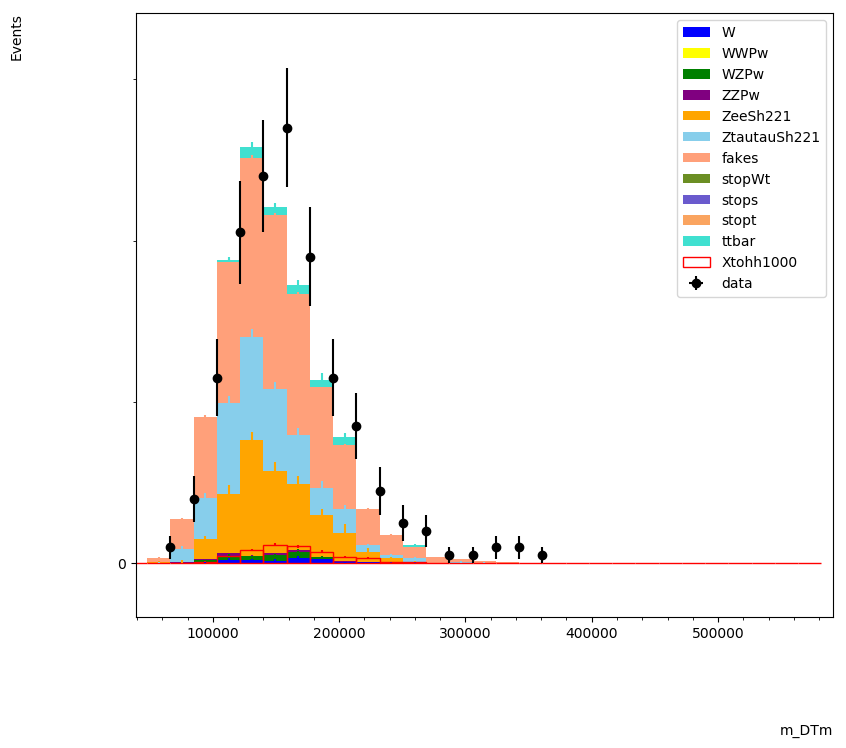

In [80]:
# Base directory
b = "/home/andrea/Escritorio/CERN data/Try3/all.root"
# Background files array
filesB = ['W', 'WWPw', 'WZPw', 'ZZPw', 'ZeeSh221', 'ZtautauSh221', 'fakes', 'stopWt', 'stops', 'stopt', 'ttbar'] 
# Signal files array
filesS = ['Xtohh1000']
# Data files array
filesD = ['data']
# Histogram generation
hist_gen(b, filesD, filesB, filesS, "Nominal", "m_DTm", "QCDCR_0tag", 30)

## TODO:

- Arreglar símbolos negativos en los axes.
- Al generar los histogramas, abajo de este se debe calcular ((Data-bkg_tot)/bkg_tot) y los Residuos (que se vería como puntos de datos). Adjuntar ambos a una sección bajo el histograma, con TRatioPlot.